In [2]:
from __future__ import print_function
import time
import intrinio_sdk
from intrinio_sdk.rest import ApiException
from pprint import pprint
import datetime as dt
from datetime import date
from datetime import timedelta
import io
from collections import Counter
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import pandas as pd

import yfinance as yf

import requests, lxml
from lxml import html

In [3]:
from Platform import Stock, Portfolio

### READ.ME ###

Only have one class, Stock. Can create an instance based off of ticker and the time period you want to back test. Then import your own data to write logic and input the start and end datetime objects into the buy method. Finally, call the .execute() method to execute all the logged trades. Then you can display the performance/original stock performance. 

## CHANGE LIST ##
##### -- Anything important that people should know got changed --

4/24/19: Changed how self.prices is stored

4/24/19: Now only using the datetime.date object to represent all dates

In [82]:
class Stock:
    def __init__(self, ticker, start_date=dt.datetime.today().date(), end_date=dt.datetime.today().date()):
        self.start = start_date
        self.end = end_date
        self.price_data = self.cache_data(ticker)
        self.orders = []
        self.price_point = 'Adj Close'
        self.ticker = ticker
        self.starting_price = self.price_data.at[start_date.isoformat(), self.price_point]
        self.stock_data = yf.Ticker(ticker)
    
    def buy(self, start_date, end_date):
        self.orders.append({ 
                            "ticker":self.ticker, 
                            "start_date":start_date, 
                            "end_date":end_date,
                            "start_price": self.price_data.at[start_date.isoformat(), self.price_point]
                          })
        #start price doesnt work if the day is a weekend or something need to build that in
        
        
    def execute(self):
        #needs to have a current gains and then a cumulative gains in the given datatable
        #cumulative gains turned into percentage
        #no need for multiple different stocks so probably can just put ticker in the init method
        self.price_data['gain'] = 0
        current_level = 0
        self.orders.sort(key=lambda x: x['start_date'])
        for order in self.orders:
            start_price = order["start_price"]
            start_ind = self.price_data.index.get_loc(order['start_date'].isoformat())
            end_ind = self.price_data.index.get_loc(order['end_date'].isoformat())
            curr_ind = start_ind
            
            while curr_ind <= end_ind:
                #hard coded indicies for adj close
                gain = self.price_data.iloc[curr_ind, 4] - start_price + current_level
                self.price_data.iloc[curr_ind, 6] = gain
                curr_ind += 1
            current_level = gain
        
        for i in range(1, len(self.price_data.index)):
            if self.price_data.iloc[i, 6] == 0.0:
                self.price_data.iloc[i, 6] = self.price_data.iloc[i - 1, 6]
        
        self.price_data['pct_gain'] = self.price_data['gain']/self.starting_price
        self.price_data['stock_pct_performance'] = (self.price_data[self.price_point] - self.starting_price)/self.starting_price
        display(self.price_data)
    
    def data(self):
        return 
        
    def query(self, parameter, value):
        return None
        
    def cache_data(self, ticker):
        return yf.download(ticker, start=self.start, end=self.end)
    
    def display_performance(self):
        self.price_data.loc[:, ['pct_gain', 'stock_pct_performance']].plot(figsize=(10,7))
        self.price_data.loc[:, ['gain']].plot(figsize=(10,7))
        plt.show()
    
    def display_chart(self):
        self.price_data.loc[:, ['Adj Close']].plot(figsize=(10,7))
        plt.show()
        
    def get_financial_data(self):
        return self.stock_data
    

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,gain,pct_gain,stock_pct_performance
Date,,,,,,,,,
2019-01-23,154.149994,155.139999,151.699997,153.919998,150.874130,23130600,0.000000,0.000000,0.000000
2019-01-24,154.110001,154.479996,151.740005,152.699997,149.678253,25441500,0.000000,0.000000,-0.007926
2019-01-25,155.479996,158.130005,154.320007,157.759995,154.638153,33535500,0.000000,0.000000,0.024948
2019-01-28,155.789993,156.330002,153.660004,156.300003,153.207047,26192100,0.000000,0.000000,0.015463
2019-01-29,156.250000,158.130005,154.110001,154.679993,151.619080,41587200,0.000000,0.000000,0.004938
...,...,...,...,...,...,...,...,...,...
2020-03-13,264.890015,279.920013,252.949997,277.970001,277.219574,92683000,34.726578,0.230169,0.837423
2020-03-16,241.949997,259.079987,240.000000,242.210007,241.556122,80605900,34.726578,0.230169,0.601044
2020-03-17,247.509995,257.609985,238.399994,252.860001,252.177368,81014000,34.726578,0.230169,0.671442


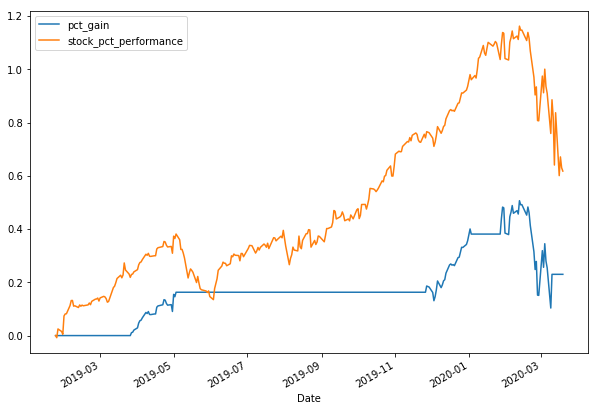

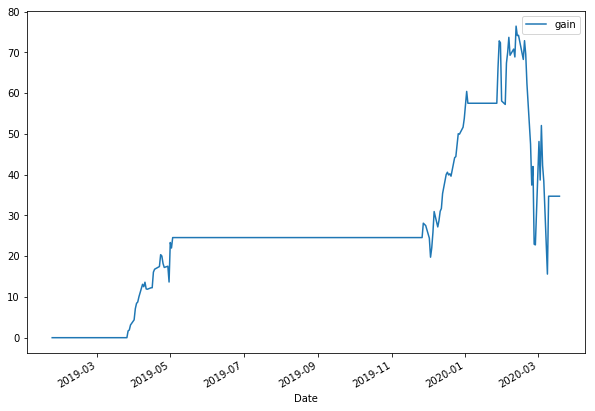

In [83]:
aapl = Stock(ticker="AAPL", start_date=dt.date(2019, 1, 23), end_date=dt.date(2020, 3, 20))
aapl.buy(start_date=dt.date(2020, 1, 27), end_date=dt.date(2020, 3, 10))
aapl.buy(start_date=dt.date(2019, 11, 26), end_date=dt.date(2020, 1, 3))
aapl.buy(start_date=dt.date(2019, 3, 26), end_date=dt.date(2019, 5, 3))

aapl.execute()
aapl.display_performance()

## Old implementation below ##

Keeping because might be useful to see how to get data

In [4]:
from __future__ import print_function
import time
import intrinio_sdk
from intrinio_sdk.rest import ApiException
from pprint import pprint
import datetime as dt
from datetime import date
from datetime import timedelta
import io
from collections import Counter
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import pandas as pd
import requests 

import requests, lxml
from lxml import html


class Stock:
    api_key = 'YnJpYW44ODIybWlAZ21haWwuY29t'
    url = 'https://api.tenquant.io/'
    def __init__(self, ticker, start_date=dt.datetime.today().date(), end_date=dt.datetime.today().date(), frequency='daily', page_size=100):
        self.ticker = ticker
        self.frequency = frequency
        self.start_date = self.parse_date(start_date)
        self.end_date = self.parse_date(end_date)
        self.data = self.get_clean_yahoo()
        self.date_range_iter = self.daterange(start_date, end_date)

        self.prices = dict(
                            zip(map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').date(), self.data['Date']),
                                self.data['Adj Close'])
                        )
        self.start_price = self.prices[self.start_date]
#         self.end_price = self.prices[self.end_date]

    def parse_date(self, date):
        """ Parses string dates in format YYYY-MM-DD to datetime objects and adjusts them
        based on frequency. """

        """ TODO:
        - Account for holidays
        """
        if not isinstance(date, dt.date):
            date = dt.datetime.strptime(date, '%Y-%m-%d').date()

        if self.frequency == 'daily':
            day = date.weekday()
            if day >= 5:
                print('The day you chose is not a weekday.')
                date -= timedelta(days=day - day%4)

        elif self.frequency == 'weekly':
            day = date.weekday()
            if day > 0:
                print('Weeks start on a Monday')
                date -= timedelta(days=day)

        elif self.frequency == 'monthly':
            print('Month starts on the 1st')
            date = date.replace(day=1)
        return date

    def get_clean_yahoo(self):
        """ Creates the appropriate URL depending on ticker, frequency and dates """
        time_period = {'daily': '1d', 'weekly': '1wk', 'monthly': '1mo'}
        freq = time_period[self.frequency]
        start_date = int(time.mktime(self.start_date.timetuple()))
        end_date = int(time.mktime(self.end_date.timetuple()))
        yahoo_url = "https://query1.finance.yahoo.com/v7/finance/download/"+ self.ticker + "?period1=" + str(start_date) + "&period2=" + str(end_date) + "&interval=" + \
                    freq + "&events=history"
#         print(yahoo_url)
        data = pd.read_csv(yahoo_url)
        # sort in ascending date
        data = data.reindex(index=data.index[::-1])
        return data

    def display_close_price(self):
        #TODO: add start and end date arguments that maybe default to the start and end date
        #TODO: decide to standardize between either datetime64ns or datetime objects
            #chosen to have all dates in self.prices to be datetime objects
        #TODO: maybe we should make our own datetime actually
        plt.figure(figsize=(10,7))
        plt.title(self.ticker + " Stock Price")
        plt.plot(pd.to_datetime(self.data['Date']), list(self.prices.values()))
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.show()
        
    def get_10k_data(self, end_date):
        end_date_formatted = end_date.strftime('%Y%m%d')
        print(end_date_formatted)
        paramters = {'key': self.api_key, 'ticker': self.ticker, 'date': end_date_formatted}
        r = requests.get(url=self.url + '/historical?ticker=' + self.ticker + '&date=' + end_date_formatted + '&key=' + self.api_key)
        print(r)
        data = r.json()
        return data
        
    def get_performance(self, start=None, end=None):
        #TODO: Implementation depends on how we choose to represent datetime
        #TODO: Fix this thing, add holidays to daterange first
        if (start == None):
            start = self.start_date
        if (end == None):
            end = self.end_date

        max_ind = len(self.prices)
        curr_ind = 0
        gains = []
        for date in self.daterange(start, end):
            if ((date - self.start_date).total_seconds() < 0):
                gains.append(0)
            elif ((self.end_date - date).total_seconds() < 0):
                gains.append(0)
            elif (curr_ind >= max_ind):
                gains.append(0)
            else:
                gains.append(self.prices[date] - self.start_price)
                curr_ind += 1
        return np.array(gains)

    def daterange(self, start_date, end_date):
        #TODO: need to implement holidays, maybe even historical holidays, not really sure
        delta = timedelta(days=1)
        while start_date <= end_date:
            if (start_date.weekday() >= 5):
                start_date += delta
                continue
            yield start_date
            start_date += delta

    def get_df(self):
        return self.data

    def display_df(self, head=None):
        if head:
            display(self.data.head(head))
        else:
            display(self.data)

class Portfolio:
    def __init__(self, capital=1000):
        self.capital = float(capital)
        self.holdings = {}

    def buy(self, ticker='', start=date.today(), end=date.today()):
        newStock = Stock(ticker, start_date=start, end_date=end)
        self.holdings[newStock] = (start, end)

    def display_performance(self):
        min_date = min(self.holdings.values(), key = lambda x: x[0])[0]
        max_date = max(self.holdings.values(), key = lambda x: x[1])[1]

        perf = np.array([self.capital] * len(list(self.daterange(min_date, max_date))))
        for i in self.holdings:
            perf += i.get_performance(start=min_date, end=max_date)

        plt.title("Portfolio Performance")
        plt.plot(list(self.daterange(min_date, max_date)), perf)
        plt.xlabel("Date")
        plt.ylabel("$")
        plt.show()
        #some of the logic is wrong, so that if two stocks are seperated, then jumps to 1000 which is not right

    def daterange(self, start_date, end_date):
        delta = timedelta(days=1)
        while start_date <= end_date:
            if (start_date.weekday() >= 5):
                start_date += delta
                continue
            yield start_date
            start_date += delta


The day you chose is not a weekday.


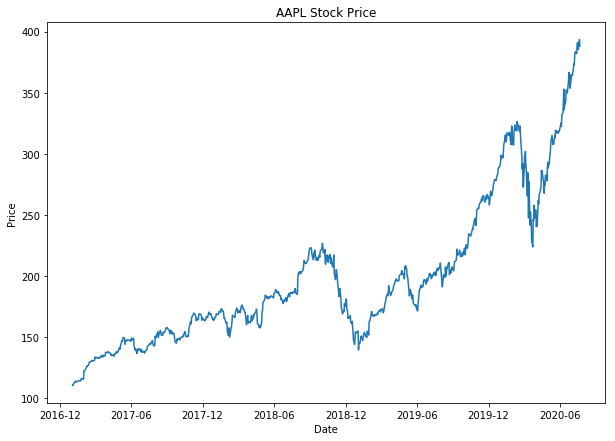

,Date,Open,High,Low,Close,Adj Close,Volume
892,2020-07-21,396.690002,397.000000,386.970001,388.000000,388.000000,25911500
891,2020-07-20,385.670013,394.000000,384.250000,393.429993,393.429993,22579500
890,2020-07-17,387.950012,388.589996,383.359985,385.309998,385.309998,23046700
889,2020-07-16,386.250000,389.619995,383.619995,386.089996,386.089996,27644400
888,2020-07-15,395.959991,396.989990,385.959991,390.899994,390.899994,38299500
887,2020-07-14,379.359985,389.019989,375.510010,388.230011,388.230011,42747300
886,2020-07-13,389.059998,399.820007,381.029999,381.910004,381.910004,47912300
885,2020-07-10,381.339996,383.920013,378.820007,383.679993,383.679993,22564300
884,2020-07-09,385.049988,385.269989,378.690002,383.010010,383.010010,31410700
883,2020-07-08,376.720001,381.500000,376.359985,381.369995,381.369995,29273000


20170103
<Response [200]>
{'assets': 321686000000.0, 'bookvalue': 128249000000.0, 'comprehensiveincome': 46666000000.0, 'comprehensiveincomeattributabletononcontrollinginterest': 0.0, 'comprehensiveincomeattributabletoparent': 46666000000.0, 'costofrevenue': 131376000000.0, 'country': 'United States', 'currencycode': 'USD', 'currentassets': 106869000000.0, 'currentliabilities': 79006000000.0, 'date': '2016-09-24', 'dividendpayments': 11965000000.0, 'dividendyield': 0.019304748664021768, 'documenttype': '10-K', 'duration': 4, 'equity': 128249000000.0, 'exchangegainslosses': 341000000.0, 'extraordaryitemsgainloss': 0.0, 'grossprofit': 84263000000.0, 'incomebeforeequitymethodinvestments': 45687000000.0, 'incomefromcontinuingoperationsaftertax': 45687000000.0, 'incomefromcontinuingoperationsbeforetax': 61372000000.0, 'incomefromequitymethodinvestments': 0.0, 'incometaxexpensebenefit': 15685000000.0, 'interestanddebtexpense': 1456000000.0, 'liabilities': 193437000000.0, 'liabilitiesandequit

In [5]:
appl2 = Stock(ticker="AAPL", start_date=date(2017, 1, 3), end_date=date.today())
appl2.display_close_price()
appl2.display_df(10)
response = appl2.get_10k_data(end_date=date(2017, 1, 3))
print(response)

In [6]:
testport = Portfolio()
testport.buy('AAPL', start=date(2020, 1, 3))
testport.buy('MSFT', start=date(2019, 4, 20))
testport.display_performance()

The day you chose is not a weekday.
The day you chose is not a weekday.
The day you chose is not a weekday.


KeyError: datetime.date(2020, 1, 20)

In [ ]:
pd.read_excel('/Users/brianmi/Berkeley-Investment-Group/aapl.xls')